# Homework 2

**Due date: Thursday, Ordibehesht 8th, 23:59**

In this homework, We are going to work with different kinds of Recurrent Neural Networks as well as Attention mechanisms. You are expected to implement your own recurrent neural network models. However, there is a single rule in this homework. 

Each subsequent model must outperform the previous model. For example, the model that you are going to implement in section 2, must outperform the model that you have implemented in section 1.

You are free to discuss the problems and ways to approach them with your classmates, but be sure to not cheat. **Cheating will not be tolerated.**

This code requires some of the dependencies of the COLAB platform, you are free to use any other platform that supports jupyter notebooks, but there is no guarantee that the code snippets will work in your setting without some modifications. 

## Import the Required Libraries

Feel free to use any other library to your heart's content (unless specified by the question), but give a link to its documentations if it is not a well known one.

In [ ]:
import nltk 
import sklearn as sk
import numpy as np
import pandas as pd 
import tensorflow as tf
from IPython.display import clear_output

## Get the Data Ready

For this task, we are going to use the Stanford SNLI dataset. This is a natural language inference task. The model is provided with two inputs, a text, and a hypothesis. The model must determine if hypothesis contradicts the text, if it is a entailment of the text, or if it is neutral with respect to the text. Thus this is a classification task. 

For more information, check the link below: 

[SNLI Dataset](https://nlp.stanford.edu/projects/snli/)

Lets start by downloading the dataset.

In [ ]:
!wget https://nlp.stanford.edu/projects/snli/snli_1.0.zip
!unzip snli_1.0.zip
clear_output()

Run the cell below to prepare the data as a pandas dataframe. and take an initial look at the data.

In [ ]:
data_train = pd.read_csv('/content/snli_1.0/snli_1.0_train.txt', encoding = "ISO-8859-1",sep='\t')
data_val = pd.read_csv('/content/snli_1.0/snli_1.0_dev.txt', encoding = "ISO-8859-1",sep='\t')
data_test = pd.read_csv('/content/snli_1.0/snli_1.0_test.txt', encoding = "ISO-8859-1",sep='\t')

In [ ]:
data_val.head(5)

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5
0,neutral,( ( Two women ) ( ( are ( embracing ( while ( ...,( ( The sisters ) ( ( are ( ( hugging goodbye ...,(ROOT (S (NP (CD Two) (NNS women)) (VP (VBP ar...,(ROOT (S (NP (DT The) (NNS sisters)) (VP (VBP ...,Two women are embracing while holding to go pa...,The sisters are hugging goodbye while holding ...,4705552913.jpg#2,4705552913.jpg#2r1n,neutral,entailment,neutral,neutral,neutral
1,entailment,( ( Two women ) ( ( are ( embracing ( while ( ...,( ( Two woman ) ( ( are ( holding packages ) )...,(ROOT (S (NP (CD Two) (NNS women)) (VP (VBP ar...,(ROOT (S (NP (CD Two) (NN woman)) (VP (VBP are...,Two women are embracing while holding to go pa...,Two woman are holding packages.,4705552913.jpg#2,4705552913.jpg#2r1e,entailment,entailment,entailment,entailment,entailment
2,contradiction,( ( Two women ) ( ( are ( embracing ( while ( ...,( ( The men ) ( ( are ( fighting ( outside ( a...,(ROOT (S (NP (CD Two) (NNS women)) (VP (VBP ar...,(ROOT (S (NP (DT The) (NNS men)) (VP (VBP are)...,Two women are embracing while holding to go pa...,The men are fighting outside a deli.,4705552913.jpg#2,4705552913.jpg#2r1c,contradiction,contradiction,contradiction,contradiction,contradiction
3,entailment,( ( ( Two ( young children ) ) ( in ( ( ( ( ( ...,( ( ( Two kids ) ( in ( numbered jerseys ) ) )...,(ROOT (S (NP (NP (CD Two) (JJ young) (NNS chil...,(ROOT (S (NP (NP (CD Two) (NNS kids)) (PP (IN ...,"Two young children in blue jerseys, one with t...",Two kids in numbered jerseys wash their hands.,2407214681.jpg#0,2407214681.jpg#0r1e,entailment,entailment,entailment,entailment,entailment
4,neutral,( ( ( Two ( young children ) ) ( in ( ( ( ( ( ...,( ( ( Two kids ) ( at ( a ballgame ) ) ) ( ( w...,(ROOT (S (NP (NP (CD Two) (JJ young) (NNS chil...,(ROOT (S (NP (NP (CD Two) (NNS kids)) (PP (IN ...,"Two young children in blue jerseys, one with t...",Two kids at a ballgame wash their hands.,2407214681.jpg#0,2407214681.jpg#0r1n,neutral,neutral,neutral,entailment,entailment


Observe that some of the columns are not required for our task. Run the code below to drop these columns. We dont drop parsed columns because they might be useful in some more complex models.

In [ ]:
data_train.drop(['captionID','pairID','label1','label2','label3','label4','label5'], axis = 1, inplace = True)
data_val.drop(['captionID','pairID','label1','label2','label3','label4','label5'], axis = 1, inplace = True)
data_test.drop(['captionID','pairID','label1','label2','label3','label4','label5'], axis = 1, inplace = True)

Additionally, obersve that our labels are in the string form. We need to convert them to integers. Run the code below to convert the labels to integer with the following convention. 

1 - Entailment = 0
2 - Neutral = 1
3 - Contradiction = 2

In [ ]:
map_dict = {'entailment':0,'neutral' : 1, 'contradiction' : 2}
data_train['gold_label'] = data_train['gold_label'].map(map_dict)
data_val['gold_label'] = data_val['gold_label'].map(map_dict)
data_test['gold_label'] = data_test['gold_label'].map(map_dict)

Great, now that we have converted our labels to an integer form, we can run a simple cleaning function on our dataset. Note that the dataset itself is fairly clean (unlike the previous dataset in HW1). Thus we are only required to remove the stop words. 
Run the code below to do the cleaning by removing nan rows and cleaning the stopwords.

In [ ]:
from nltk.corpus import stopwords
import string
nltk.download('stopwords')
stop = stopwords.words('english')
data_train = data_train.dropna(axis = 0)
data_val = data_val.dropna(axis = 0)
data_test = data_test.dropna(axis = 0)
data_train['sentence1'] = data_train['sentence1'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
data_train['sentence2'] = data_train['sentence2'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
data_val['sentence1'] = data_val['sentence1'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
data_val['sentence2'] = data_val['sentence2'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
data_test['sentence1'] = data_test['sentence1'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
data_test['sentence2'] = data_test['sentence2'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
def remove_punc(x) : 
  x[5] = x[5].translate(str.maketrans('','',string.punctuation))
  x[6] = x[6].translate(str.maketrans('','',string.punctuation))
  return x
data_train = data_train.apply(remove_punc, axis = 1)
data_val = data_val.apply(remove_punc, axis = 1)
data_test = data_test.apply(remove_punc, axis = 1)
clear_output()

In [ ]:
data_train

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2
0,1.0,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,( ( A person ) ( ( is ( ( training ( his horse...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person horse jumps broken airplane,A person training horse competition
1,2.0,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,( ( A person ) ( ( ( ( is ( at ( a diner ) ) )...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person horse jumps broken airplane,A person diner ordering omelette
2,0.0,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,"( ( A person ) ( ( ( ( is outdoors ) , ) ( on ...",(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person horse jumps broken airplane,A person outdoors horse
3,1.0,( Children ( ( ( smiling and ) waving ) ( at c...,( They ( are ( smiling ( at ( their parents ) ...,(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,(ROOT (S (NP (PRP They)) (VP (VBP are) (VP (VB...,Children smiling waving camera,They smiling parents
4,0.0,( Children ( ( ( smiling and ) waving ) ( at c...,( There ( ( are children ) present ) ),(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,(ROOT (S (NP (EX There)) (VP (VBP are) (NP (NN...,Children smiling waving camera,There children present
...,...,...,...,...,...,...,...
550147,2.0,( ( ( ( Four dirty ) and ) ( barefooted childr...,( ( four kids ) ( ( won awards ) ( ( ( for ` )...,(ROOT (NP (NP (CD Four) (NNS dirty)) (CC and) ...,(ROOT (S (NP (CD four) (NNS kids)) (VP (VBD wo...,Four dirty barefooted children,four kids awards cleanest feet
550148,1.0,( ( ( ( Four dirty ) and ) ( barefooted childr...,( ( ( ( ( ( four ( homeless children ) ) ( had...,(ROOT (NP (NP (CD Four) (NNS dirty)) (CC and) ...,(ROOT (S (S (NP (CD four) (JJ homeless) (NNS c...,Four dirty barefooted children,four homeless children shoes stolen feet dirty
550149,1.0,( ( A man ) ( ( is ( surfing ( in ( ( a bodysu...,( ( ( A man ) ( in ( a bodysuit ) ) ) ( ( is (...,(ROOT (S (NP (DT A) (NN man)) (VP (VBZ is) (VP...,(ROOT (S (NP (NP (DT A) (NN man)) (PP (IN in) ...,A man surfing bodysuit beautiful blue water,A man bodysuit competing surfing competition
550150,2.0,( ( A man ) ( ( is ( surfing ( in ( ( a bodysu...,( ( ( A man ) ( in ( a ( business suit ) ) ) )...,(ROOT (S (NP (DT A) (NN man)) (VP (VBZ is) (VP...,(ROOT (S (NP (NP (DT A) (NN man)) (PP (IN in) ...,A man surfing bodysuit beautiful blue water,A man business suit heading board meeting


Great, now that we have cleaned the data. We can get into training some models. :)

## 1. Dense Neural Networks

As a baseline, we start by training a dense neural network to do our prediction. As you are already familiar with this kind of neural network, we will do the training for you. And just ask you a few questions. 

To get started, lets start by developing our embedding. 

### 1.1. Training the model

Note that we have two inputs in our dataset that we must feed to the model. Run the code below to develop embedding layers for each input. 

In [ ]:
training_data_text = np.array(data_train['sentence1'])
training_data_hyp = np.array(data_train['sentence2'])
vectorizer_text = tf.keras.layers.TextVectorization(max_tokens=25000,output_sequence_length=200)
vectorizer_hyp = tf.keras.layers.TextVectorization(max_tokens=25000,output_sequence_length=200)
training_data_text_ds = tf.data.Dataset.from_tensor_slices(training_data_text).batch(128)
training_data_hyp_ds = tf.data.Dataset.from_tensor_slices(training_data_hyp).batch(128)
vectorizer_text.adapt(training_data_text_ds)
vectorizer_hyp.adapt(training_data_hyp_ds)

Great, now we have vectorizers for our two inputs. Lets develop the embedding matrix and layers. For this one, we are going to use the GLOVE embeddings, but feel free to use whatever you see fit. 

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip
clear_output()

In [ ]:
import os
voc_text = vectorizer_text.get_vocabulary()
voc_hyp = vectorizer_hyp.get_vocabulary()
word_index_text = dict(zip(voc_text, range(len(voc_text))))
word_index_hyp = dict(zip(voc_hyp, range(len(voc_hyp))))
path_to_glove_file = os.path.join(
    os.path.expanduser("~"), "/content/glove.6B.200d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))
num_tokens_text = len(voc_text) + 2
embedding_dim = 200
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix_text = np.zeros((num_tokens_text, embedding_dim))
for word, i in word_index_text.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix_text[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

num_tokens_hyp = len(voc_hyp) + 2
hits = 0
misses = 0

embedding_matrix_hyp = np.zeros((num_tokens_hyp, embedding_dim))
for word, i in word_index_hyp.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_hyp[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Found 400000 word vectors.
Converted 17136 words (2588 misses)
Converted 20943 words (4057 misses)


Now that we have created our embedding matrices, lets build our model. Run the code below to build the model.

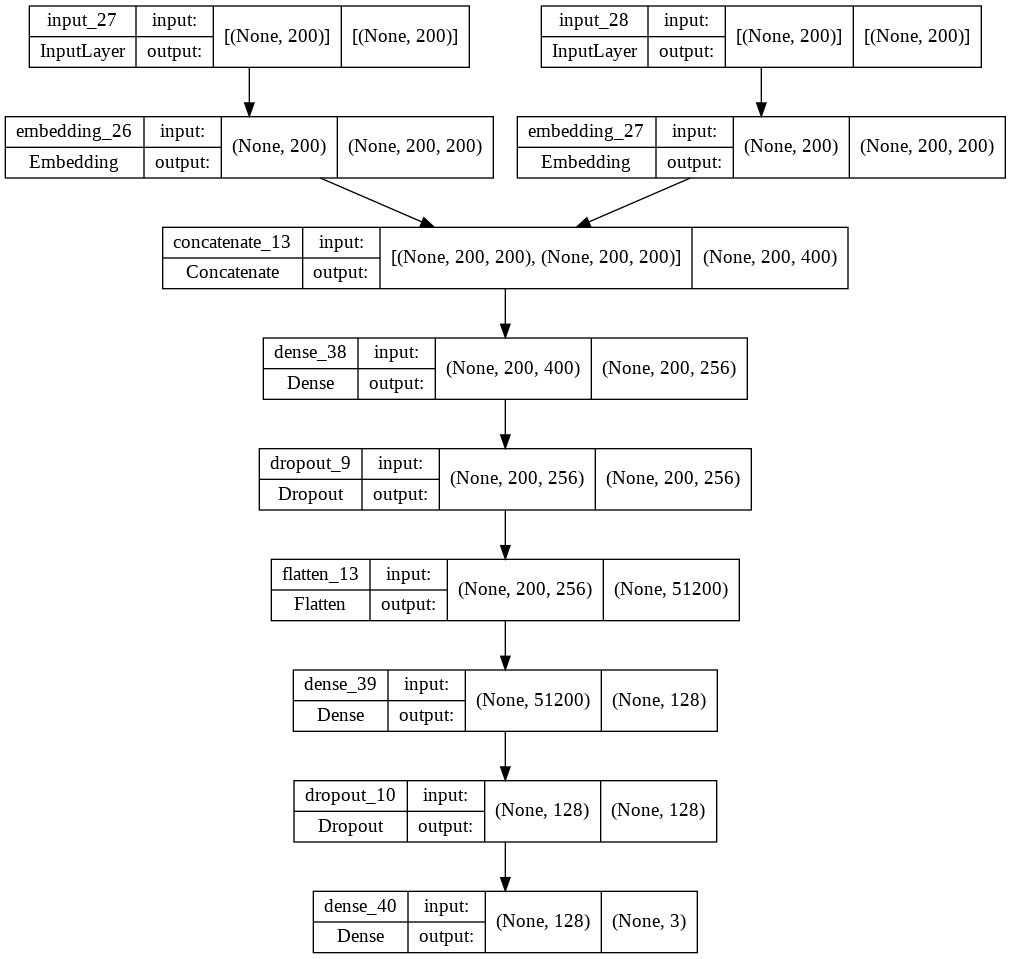

In [ ]:
embedding_layer_text = tf.keras.layers.Embedding(num_tokens_text,embedding_dim,embeddings_initializer= tf.keras.initializers.Constant(embedding_matrix_text),trainable = False)
embedding_layer_hyp = tf.keras.layers.Embedding(num_tokens_hyp,embedding_dim,embeddings_initializer= tf.keras.initializers.Constant(embedding_matrix_hyp),trainable = False)
inp1 = tf.keras.layers.Input((200,),dtype = 'int64')
embedding_text = embedding_layer_text(inp1)
inp2 = tf.keras.layers.Input((200,),dtype = 'int64')
embedding_hyp = embedding_layer_hyp(inp2)
conc = tf.keras.layers.Concatenate()([embedding_text,embedding_hyp])
x = tf.keras.layers.Dense(256, activation = 'relu')(conc)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.6)(x)
output = tf.keras.layers.Dense(3,activation = 'softmax')(x)
model = tf.keras.models.Model(inputs = [inp1,inp2],outputs = output)
tf.keras.utils.plot_model(model, to_file='model_1.png', show_shapes=True)

Great, now that we have our model, lets do a quick training on it.

In [ ]:
train_text = vectorizer_text(np.array([[s] for s in training_data_text])).numpy()
train_hyp = vectorizer_hyp(np.array([[s] for s in training_data_hyp])).numpy()
train_labels = np.array(data_train['gold_label'])
val_data_text = np.array(data_val['sentence1'])
val_data_hyp = np.array(data_val['sentence2'])
val_text = vectorizer_text(np.array([[s] for s in val_data_text])).numpy()
val_hyp = vectorizer_hyp(np.array([[s] for s in val_data_hyp])).numpy()
val_labels = np.array(data_val['gold_label'])
opt = tf.keras.optimizers.Adam()
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["acc"]
)
model.fit(x = [train_text,train_hyp],y=train_labels, batch_size = 128, validation_data=[[val_text,val_hyp],val_labels],epochs = 4)

Epoch 1/4
4292/4292 [==============================] - 97s 22ms/step - loss: 0.9146 - acc: 0.5697 - val_loss: 0.8209 - val_acc: 0.6404
Epoch 2/4
4292/4292 [==============================] - 97s 23ms/step - loss: 0.8527 - acc: 0.6133 - val_loss: 0.7860 - val_acc: 0.6641
Epoch 3/4
4292/4292 [==============================] - 96s 22ms/step - loss: 0.8345 - acc: 0.6265 - val_loss: 0.7784 - val_acc: 0.6747
Epoch 4/4
4292/4292 [==============================] - 96s 22ms/step - loss: 0.8241 - acc: 0.6333 - val_loss: 0.7683 - val_acc: 0.6761


Now that we have trained our model, lets test it using our test dataset.

In [ ]:
test_data_text = np.array(data_test['sentence1'])
test_data_hyp = np.array(data_test['sentence2'])
test_text = vectorizer_text(np.array([[s] for s in test_data_text])).numpy()
test_hyp = vectorizer_hyp(np.array([[s] for s in test_data_hyp])).numpy()
test_labels = np.array(data_test['gold_label'])
model.evaluate(x=[test_text,test_hyp],y = test_labels)

307/307 [==============================] - 3s 8ms/step - loss: 0.7557 - acc: 0.6809


[0.7557432055473328, 0.680883526802063]

### 1.2. Another Approach?

Note that we have developed two separate embeddings in our approach, one for the original text, and one for the hypothesis. Can you think of another method by which we can train our model? Explain your method and hypothesize if you think this second approach is better than the original one or not.

**Type Your Answer Here**

Great, now, having thought about a second approach and having contemplated its possible performance, develop, train, and test a model using your own approach in the cell below. You may take inspiration from the model that we just implemented. :)

For this subtask **alone**, your model does not need to outperform our previous model.

In [ ]:
# Develop and train your model here

In [ ]:
# Test your model here

Good job. We have now implemented two possible methods for solving our problem. With this new knowledge in mind, answer the questions below. 

1 - Does the second model outperform the first one? Is the difference significant? 

2 - What are the main differences between these two models?

3 - Which approach do you think is better in general? Explain your answer

**Type Your Answer Here**

### 1.3. Limitations

We have observed that a simple dense neural network can perform reasonably well in the SNLI task. However, as you already know, there are limitations to using dense networks in NLP tasks. 

Name two of the limitations that come up when using a dense network to tackle NLP problems. Explain each limitation and come up with solutions that can be used to tackle them

**Type Your Answer Here**

## 2. Simple Recurrent Neural Networks

To fix the problems encountered while using dense neural networks, recurrent neural networks were introduced. These models read the input one at a time and have a temportal knowledge of the input, which helps them immensely while working with timestamped data, such as natural language. 

In this section, you are going to implement your own simple recurrent neural network. 

### 2.1. Implementing the Recurrent Neural Network 

To start, we are going to implement a simple recurrent neural network without any extensions. This is the simplest form of a recurrent network, but still fixes some of the problems that dense networks have. 

Write your code below such that a simple recurrent neural network is created, trained, and tested on our data. Don't forget our rule.

In [ ]:
# Develop and Train your model here

In [ ]:
# Test your model here

Great job. Observe that it is very uncommon to see deep recurrent neural networks. Most of the models usually use one or two layers of recurrent layers. With this knowledge in mind, answer the questions below. 

1 - Why do you think it is the case that deeper recurrent neural networks are uncommon? 

2 - What do you think the difference between a wider recurrent network and a deeper one is? If your model is struggling to learn, increasing which of these is the first step to take? 

You may play with your model to get the answer for these questions.

**Type Your Answer Here**

### 2.2 Dropout in Recurrent Neural Networks

Complex Neural Networks are prone to overfitting. One of the best ways to tackle this problem is using dropout. Unlike other conventional networks, dropout can be applied in a multitude of ways in recurrent neural networks. Namely, one can either apply the dropout cellwise, or layerwise while developing a recurrent neural network. With this knowledge in mind, answer the questions below. 

1 - What is the difference between cellwise and layerwise dropout? 

2 - Which one of these dropouts is more commonly used? Why? What happens if we use the other one? 

3 - Is there a difference between the optimal threshold of two dropouts? If yes, What is the optimal threshold for each of them? 

** Type Your Answer Here**

Now that you have become familiar with dropout in recurrent neural networks. Extend your model such that it uses the best form of dropout. Write your code below.

In [ ]:
# Develop and Train your Model Here

In [ ]:
# Test Your Model Here

Do you see any differences in model performance? Does the model train faster/slower? Is the model more stable? Explain your answer.

**Type Your Answer Here**

### 2.3 Limitations

Being the simplest form of recurrent neural network, simple RNN's have a plethora of problems. Answer the questions below. 

1 - What is the main problem with simple RNN's? Explain the problem and give a solution. 

2 - In what context is this problem boldly observable? Give an example. 

3 - What is the common solution for fixing the problems with recurrent neural networks? Do you think thee are other ways to tackle this problem?

**Type Your Answer Here**

## Gated Recurrent Networks 

Gated Recurrent Networks were introduced to fix the shortcomings of simple recurrent networks and prior to transformer models, they were the state of the art models with respect to model performance in NLP tasks. In this section, we are going to implement our own gated recurrent network and answer some questions about them. 

### 3.1 Different kinds of gated recurrent networks. 

In general, there are two types of gated recurrent networks, Gated Recurrent Units (GRU) and Long-Short-Term-Memory Networks (LSTM). They are essentially similar to each other, but have a few differences. 

What are the differences and similarities between these two networks? Do you think one network is better than the other? Explain your answer

**Type Your Answer Here**

### 3.2 Implementing the Gated Recurrent Network

Now that we are familiar with these type of networks, it is time to implement our own gated recurrent network. Write your code below such that a gated recurrent network of your own choice is created, trained, and tested on our dataset. 

In [ ]:
# Create and Train Your Model Here

In [ ]:
# Test your Model Here

### 3.3 Tackling the Old Problems

In general, classic recurrent neural networks have two main problems, namely, gradient vanishing and gradient explosion. With this knowledge in mind, answer the questions below.

1 - Describe each of these problems. How can they hinder the performance of the model? 

2 - What do you propose for fixing each of these problems? why? 

3 - Which of these problems is fixed due to the nature of the gated recurrent networks? How does the gated architecture manage to fix it? 

4 - Is there a feasible method for fixing the other problem? Explain your answer. 

**Type Your Answer Here**

Now that you are aware of the problems, and know that even gated recurrent networks don't fix at least one of them out of the box. Extend your model such that the other problem is also tackled. 

In [ ]:
# Create and Train your model here

In [ ]:
# Test your model here

Do you see any signifcant differences in model performance? Why? In what cases do you think a significant difference can be seen? 

**Type Your Answer Here**

### 3.4 Limitations

While being state of the art prior to transformer models, gated recurrent models still have a few problems. With this knowledge in mind, answer the questions below

1 - What do you think are the main problems with gated recurrent networks? How do you propose fixing them? 

2 - Now that you are a bit familiar with transformer models, discuss how these models manage to fix the problems with gated networks. What are their fundamental differences? 

**Type Your Answer Here**

## 4. Attention Mechanism

Attention is widely used in almost every NLP task. In essence, attention gives the model the ability to look at the relevant features from the past steps and take them into consideration while creating the representation. It has been shown that attention mechanism can greatly improve the performance of the model. 

In this section, we will work a bit with attention in recurrent networks.

### 4.1 Different Kinds of Attention

There are many kinds of attention that are used in NLP tasks. Some are more complex than others. First, lets take a look at some of the basic attention mechanisms. Answer the questions below. 

1 - Take a look at Dot Product attention. Describe how it works and why do you think it is a good attention mechanism? 

2 - Take a look at Additive attention. Describe how it works and why do you think it is a good attention mechanism? 

3 - Compare two of the attention types, what do you think are the main differences? Which one is better? Why? 

4 - Do you think the inner workings of gated recurrent networks can be regarded as some form of attention mechanism? Explain your answer.

### 4.2 Integrating Attention Into Your Model

Now that we have a better understanding of attention in NLP models. It is time to implement our own attention into a gated recurrent network. Extend your model from the previous section such that it can utilize the attention mechanism of your choice while creating representations. 

Note that as we have two inputs, we can approach this problem from two different perspectives in this case. We can either make each representation attend to previous representations of the same input by using the dot product on the earlier representations for example. This is called self-attention. Or, we can alternatively use attention on both inputs, using the dot product of representations from one input on the other. You can use either form of attention in this section, or even a combination of both if you like. :) 

In [ ]:
#Create and Train your model here

In [ ]:
#Test your model here

### 4.3 Error Analysis

Now that we have created the best possible model using classical recurrent neural networks. We should do an error analysis to see how our model performs on different tasks. 

Complete the function below such that given a history of model output, and the gold labels, a confusion matrix is created showcasing the True and False Classifications. 

Your final output should look like the matrix below, or its transpose. 

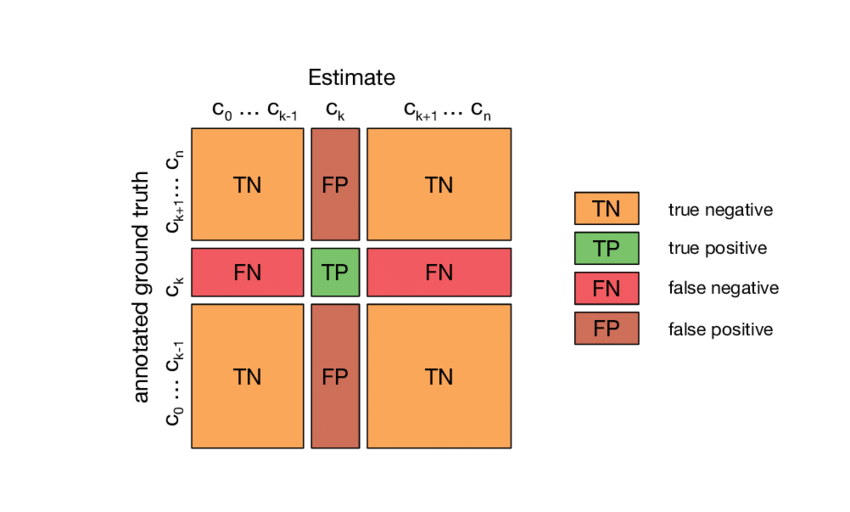

In [ ]:
def create_confusion_matrix(history,gold_labels) : 
  print('Write Your Code here')
create_confusion_matrix(history,test_labels)

Having created the confusion matrix, we can now have a better look at our model performance. Answer the questions below based on your confusion matirx. 

1 - In what class does the model perform the best? 

2 - In what class does the model perform the worst? 

3 - What two classes does the model confound with each other the most? What do you think the reason behind this is? Can you think of a method by which we can decrease this confusion? 

4 - Aside from confusion matrix, can you think of any other error analysis tools that may come in handy while analyzing our model?

**Type Your Answer Here**

## Submission

Congratulations! You finished the assignment & you're ready to submit your work. Please follow the instructions:

1. Check and review your answers. Make sure all of the cell outputs are what you want. 
2. Select File > Save.
3. **Fill your information** & run the cell bellow.
4. Run **Make Submission** cell, It may take several minutes and it may ask you for your credential.
5. Run **Download Submission** cell to obtain your submission as a zip file.
6. Grab the downloaded file (`nlp_asg02__xx__xx.zip`) and hand it over in microsoft teams.





In [ ]:
#@title Enter your information & "RUN the cell!!" { run: "auto" }
student_id = "123124" #@param {type:"string"}
student_name = "5121312" #@param {type:"string"}

print("your student id:", student_id)
print("your name:", student_name)


from pathlib import Path

ASSIGNMENT_PATH = Path('asg02')
ASSIGNMENT_PATH.mkdir(parents=True, exist_ok=True)

your student id: 123124
your name: 5121312


In [ ]:
#@title Make submission
! pip install -U --quiet PyDrive > /dev/null
! pip install -U --quiet jdatetime > /dev/null

# ! wget -q https://github.com/github/hub/releases/download/v2.10.0/hub-linux-amd64-2.10.0.tgz 


import os
import time
import yaml
import json
import jdatetime

from google.colab import files
from IPython.display import Javascript
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

asg_name = 'NLP_Assignment_2'
script_save = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''
# repo_name = 'iust-deep-learning-assignments'
submission_file_name = 'nlp_asg02__%s__%s.zip'%(student_id, student_name.lower().replace(' ',  '_'))

sub_info = {
    'student_id': student_id,
    'student_name': student_name, 
    'dateime': str(jdatetime.date.today()),
    'asg_name': asg_name
}
json.dump(sub_info, open('info.json', 'w'))

Javascript(script_save)

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = drive.ListFile({'q':"title='%s.ipynb'"%asg_name}).GetList()[0]['id']
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('%s.ipynb'%asg_name) 

! jupyter nbconvert --to script "$asg_name".ipynb > /dev/null
! jupyter nbconvert --to html "$asg_name".ipynb > /dev/null
! zip "$submission_file_name" "$asg_name".ipynb "$asg_name".html "$asg_name".txt info.json > /dev/null

print("##########################################")
print("Done! Submisson created, Please download using the bellow cell!")

[NbConvertApp] Converting notebook NLP_Assignment_2.ipynb to script
[NbConvertApp] Writing 45316 bytes to NLP_Assignment_2.txt
[NbConvertApp] Converting notebook NLP_Assignment_2.ipynb to html
[NbConvertApp] Writing 888937 bytes to NLP_Assignment_2.html
##########################################
Done! Submisson created, Please download using the bellow cell!


In [ ]:
drive.ListFile({'q':"title='%s.ipynb'"%asg_name}).GetList()[0]['id']

'1BzGHlxurFt5aN9aKqvsBdcYydQxGhCaB'

In [ ]:
files.download(submission_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>